# Homework 2, Jan Rosa

In [1]:
using LinearAlgebra, Statistics, Plots, Random, Distributions, QuantEcon, NLsolve, Polynomials, BenchmarkTools, StaticArrays 

## Exercise 2 from "Fundamental types" 

In [2]:
"""
function generate_AR_seq generate a T realizations of the AR process, given the parameters of the process and a starting pointb y_0   
"""
function generate_AR_seq(γ, θ, σ; T=150, y_0=0.0)
    #Here I compute the process values in a slightly faster way, by simulating all epislons at once. 
    @assert T > 0 #Assume that T>0, else throw error. Then I will use T as dimmension of all matrices 
    
    seq = zeros(T) #initialize the generated process sequence of random variables
    ϵ = randn(T) #generate all epsilons vector at once
    weights_matrix = zeros(T,T) #initialize the weights matrix, enables to compute all process realizations at once
    
    for i in 1:T
        weights_matrix[ i, 1:i] = [θ^(i-j) for j in 1:i] #compute weights of epsilon for all generated process realizations
    end
    
    seq = weights_matrix*(γ.+ϵ)+weights_matrix[1,:].*y_0 
    
    return(AR_sequence = seq)
end

"""
function rolling_avg simply generate rolling averge for any provided sequence (process)
"""
function rolling_avg(process)
    T =  length(process)
    if(T>0) #check if number of simulations is positive integer
        roll_mean = zeros(T)
        for i in 1:T
            roll_mean[i] = mean(process[1:i]) #compute  rolling mean 
        end 
        return(roll_mean) 
    end
end


"""
function AR_MC is a Monte Carlo simulation of the process AR which can be generated by function generate_AR_seq 
"""
function AR_MC(γ, θ, σ, N; seq_len=150, y_0=0.0 ) 
    if(N>0) #check if number of simulations is positive integer
        realizations = zeros(N,seq_len)
        for i in 1:N
            realizations[i, :] = generate_AR_seq(γ, θ, σ, T= seq_len, y_0=y_0) #generate realizations
        end
        return(realizations) 
    end
end

AR_MC

In [3]:
#Solving the exercise
#set parameters
γ = 1.0
σ = 1.0
θ = [0.8, 0.9, 0.98]
T=150
#I solve the the first subquestions, ploting the generated process
gen_seq = zeros(length(θ), T)
roll_seq = zeros(length(θ), T)
for i in eachindex(θ)
    gen_seq[i,:] = generate_AR_seq(γ, θ[i], σ, T=T)
    roll_seq[i,:] = rolling_avg(gen_seq[i,:])
end






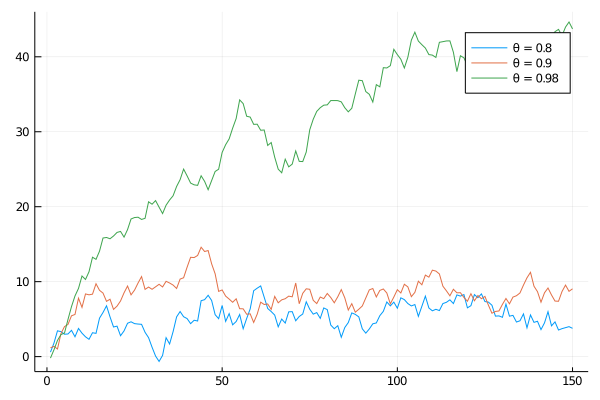

In [4]:
#Parts for plots works for the concrete number (3) of  theta parameters
fig = plot()
for i in eachindex(θ)
    plot!(gen_seq[i,:], label="θ = $(θ[i])")
end

display(fig)

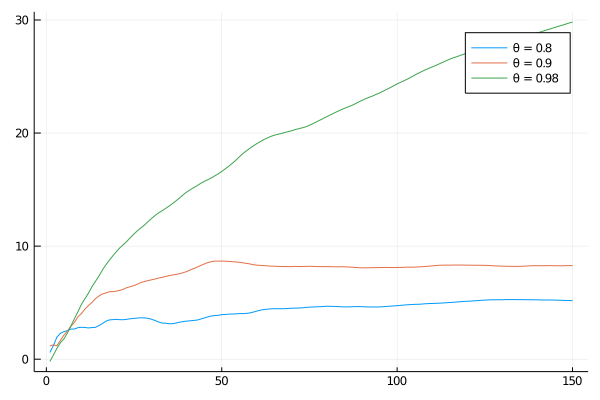

In [5]:
#second subquestion: plotting the rolling average
fig = plot()
for i in eachindex(θ)
    plot!(roll_seq[i,:], label="θ = $(θ[i])")
end

display(fig)


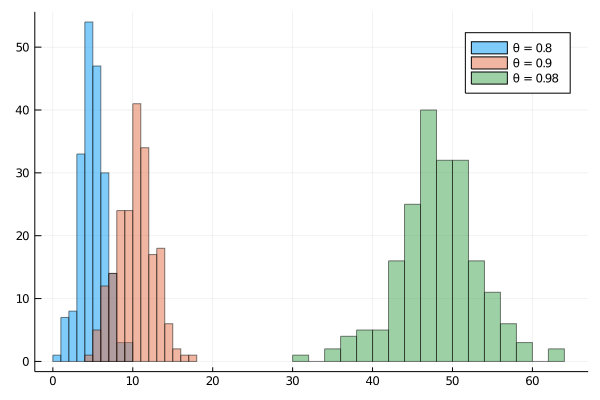

In [6]:
#third sub exercise, plotting the last value of the simulations
N=200
last_vals=zeros( length(θ), N)
for i in eachindex(θ)
    realization = AR_MC(γ, θ[i], σ, N,seq_len=T)
    last_vals[i,:] = realization[:,T]
end
#Plot the histograms

histogram( last_vals[1,:], alpha = 0.5, label = "θ = $(θ[1])")
histogram!( last_vals[2,:], alpha = 0.5, label = "θ = $(θ[2])")
histogram!( last_vals[3,:], alpha = 0.5, label = "θ = $(θ[3])")

In [7]:
# fourth subquestion, I print here the obtained avergges and variances
for i in eachindex(θ)
    println("The simulated average of the last values for θ = $(θ[i])  is $(mean(last_vals[i,:]))" )
    var = mean(last_vals[i,:].^2)-  mean(last_vals[i,:])^2
    println("while the simulated variance is $var" )
end


The simulated average of the last values for θ = 0.8  is 5.014654733010255
while the simulated variance is 2.4900640283949045
The simulated average of the last values for θ = 0.9  is 10.401085047110762
while the simulated variance is 5.415267092539423
The simulated average of the last values for θ = 0.98  is 48.249453119485416
while the simulated variance is 23.97133580658965


## Exercise 3 from "Fundamental types" 

In [8]:

"""
function generate_x generates x_1, x_2 as it was described in the exercise  
"""
function generate_x(N; mean_1=0.0,var_1 =1.0,mean_2=0.0,var_2 =1.0 )
    if(mean==0.0&&var==1.0 && mean_2==0.0&&var_2 ==1.0) #assume that rx_1 and x_2 are normal
        return(x_1 = randn(N), x_2 = randn(n))
    else
        return(x_1 = rand(Normal(mean_1, var_1),N), x_2 =  rand(Normal(mean_2, var_2),N))
    end
end

"""
function generate_data generates y as it was described in the exercise for given parameters 
"""
function generate_data(N, a,b,c,d,σ ;mean_1=0.0,var_1 =1.0,mean_2=0.0,var_2 =1.0 )
    x_1,x_2 = generate_x(N; mean_1=mean_1,var_1 =var_1,mean_2=mean_2,var_2 =var_2 )
    w = randn(N)
    y = hcat(ones(N),x_1,x_1.^2, x_2)*[d, a,b,c]+σ*w
    return(x_1=x_1,x_2=x_2,y=y)
end

"""
This function provides simple OLS estimation 
"""
function OLS_est(x, y)
    N_1 = length(y)
    N_2 = size(x,1)
    
    if(N_1==N_2!=0)
        beta = (x'*x)\(x'*y)
        res = y-x*beta
        σ = sqrt(1/(max(length(y)-1.0,1.0))*sum(res.^2))
        return(beta=beta, σ=σ)
    else
        return("error, wrong dim size")     
    end             
end

"""
simple Monte Carlo estimation of the OLS estimates
"""
function OLS_MC(N, M, a,b,c,d, σ)
    @assert M>0
    a_est = zeros(M)
    b_est = zeros(M)
    c_est = zeros(M)
    d_est = zeros(M)
    sigma_est = zeros(M)
    for i in 1:M
        X_1,X_2,Y = generate_data(N, a,b,c,d, σ)
        data= hcat(ones(N),X_1,X_1.^2, X_2)
        beta, sigma_est[i] = OLS_est(data, Y)
        d_est[i] = beta[1]
        a_est[i] = beta[2]
        b_est[i] = beta[3]
        c_est[i] = beta[4]
    end
    return(a_est=a_est, b_est=b_est, c_est=c_est, d_est=d_est,sigma_est=sigma_est)
end



OLS_MC

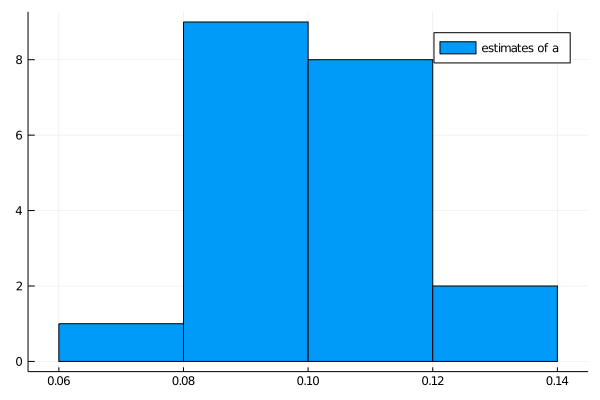

In [9]:
#Solution of the exercise, I assumed that it combines to one exercise: to obtain histr=ograms of the obtained extimates of a,b,c,d, \sigma. I generate the process 20 times at each MC simulation.   

#parameters 
a = 0.1
b = 0.2
c = 0.5
d = 1.0
σ = 0.1
N = 50
M = 20

#MC simulation
a_est, b_est,c_est, d_est, σ_est = OLS_MC(N, M, a,b,c,d, σ)
histogram( a_est, label = "estimates of a")


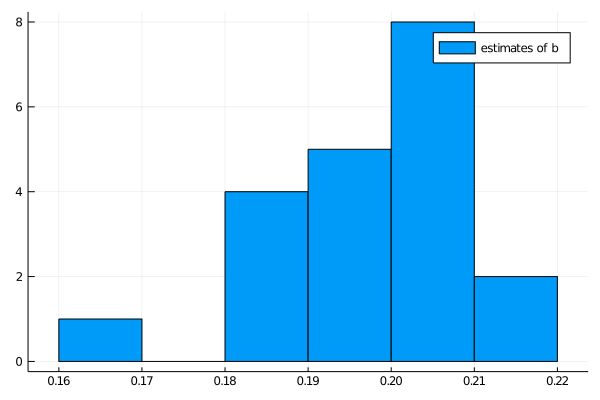

In [10]:
histogram( b_est, label = "estimates of b")

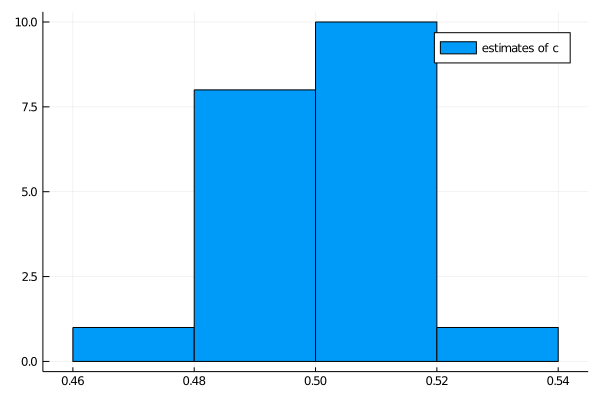

In [11]:
histogram( c_est, label = "estimates of c")

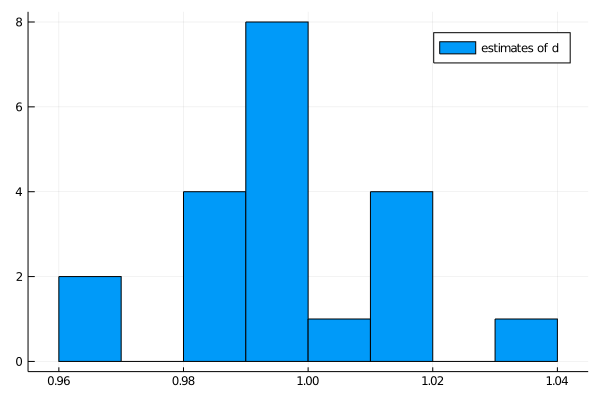

In [12]:
histogram( d_est, label = "estimates of d")

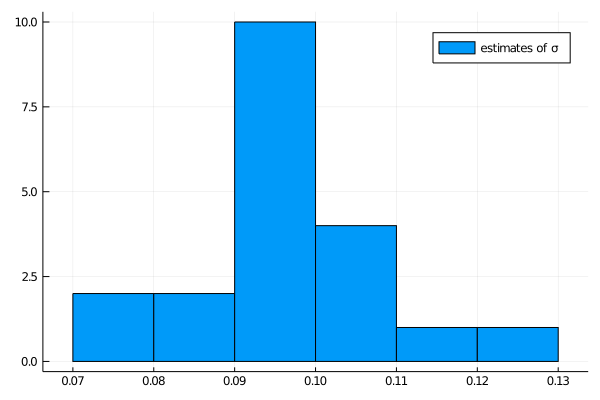

In [13]:
histogram( σ_est, label = "estimates of σ")

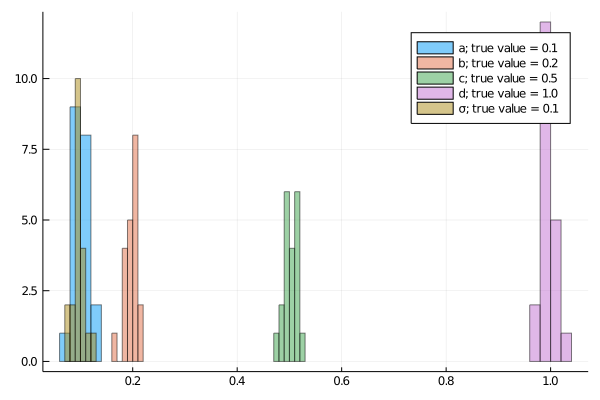

In [23]:
# Emma's Addition
# Modified to include a histogram of all estimates

histogram(a_est,alpha=0.5,label="a; true value = $a")
histogram!(b_est,alpha=0.5,bins=5,label="b; true value = $b")
histogram!(c_est,alpha=0.5,bins=5,label="c; true value = $c")
histogram!(d_est,alpha=0.5,bins=5,label="d; true value = $d")
histogram!(σ_est,alpha=0.5,bins=5,label="σ; true value = $σ")

## Exercise 4 from "Fundamental types" 

In [14]:
# start by coping the code from ex 1

function compute_asymptotic_var(A, Σ;
                                S0 = Σ * Σ',
                                tolerance = 1e-6,
                                maxiter = 500)
    V = Σ * Σ'
    S = S0
    err = tolerance + 1
    i = 1
    while err > tolerance && i ≤ maxiter
        next_S = A * S * A' + V
        err = norm(S - next_S)
        S = next_S
        i += 1
    end
    iter = i
    return S, iter
end
A = [0.8  -0.2;
     -0.1  0.7]

Σ = [0.5 0.4;
     0.4 0.6]



2×2 Array{Float64,2}:
 0.5  0.4
 0.4  0.6

In [15]:
solution_ex1, iter_1 = compute_asymptotic_var(A, Σ)

([0.6712283007263011 0.6334755235498987; 0.6334755235498988 0.858873651268526], 50)

In [16]:
#Here my code starts

"""
function Asymp_variance_step provides a one step of the algorithm for NL solve
"""
function Asymp_variance_step(S, M_1, M_2)
    N = size(M_1,1)
    V = M_2* M_2'
    S_matrix = reshape(S,N,N)
    S_matrix_new = M_1*S_matrix*M_1'+V
    return(S_new=reshape(S_matrix_new, 2*N))
end

"""
function designed to solve an exercise 4, return the fixed poit of the problem described in the exercise and the number of iterations   
"""
function compute_asymptotic_var_NL(A, Σ;
                                S0 = reshape(Σ * Σ',2*size(Σ,1)),
                                tolerance = 1e-6,
                                maxiter = 500)
    N=size(A,1)
    f(S) = Asymp_variance_step(S, A, Σ)
    solution_NL = fixedpoint(f, S0; iterations = maxiter, ftol= tolerance)
    S_fixed = reshape(solution_NL.zero, N,N)
    iter = solution_NL.iterations
    return(S_fixed, iter)
end

solution_ex4, iter_4 =  compute_asymptotic_var_NL(A, Σ)

([0.6712314073226504 0.6334739702517158; 0.6334739702517158 0.8588744279176176], 5)

I observe that hand-coded method need 50 iterations while NL_solve method need only 5 iterations. 

## Excercise 1 from "Introduction to Types and Generic Programming"

For the first subpoint I explore two abstract types which are the super types of declared matrix 

In [17]:
SA_A = SMatrix{2,2}(rand(2,2))
SA_x = SVector{2}(rand(2)) 

println("First abstract type is ",supertype(typeof(SA_A)))

println("Second described abstract type is ",supertype(typeof(SA_x)))


First abstract type is StaticArray{Tuple{2,2},Float64,2}
Second described abstract type is StaticArray{Tuple{2},Float64,1}


Thus I observe in case of the static arrays. There are define as StaticArray{data continer ,Number subtype/filling,dimension}. The each abstract type need to define dimmensioins (1 in case of SA_x or 2 in case of SA_A), what are types (of number/string?) which are elements of the Array here in both cases it is Float64. Lastly, Each abstract object need to describe the data which are contained in the concrete array subtype, here it need to be a Tuple{2,2} for SA_A or Tuple{2} for SA_x. 

Next, let's move to the concrete types, I write the type and abstract type of three concrete types:

In [18]:
SA_y = SVector{2}([1.0+1.0im, 3.14+2.0im]) 
println("concrete type of SA_A is ", typeof(SA_A)," while abstract type is ",supertype(typeof(SA_A)))
println("concrete type of SA_A is ", typeof(SA_x)," while abstract type is ",supertype(typeof(SA_x)))
println("concrete type of SA_A is ", typeof(SA_y)," while abstract type is ",supertype(typeof(SA_y)))

concrete type of SA_A is SArray{Tuple{2,2},Float64,2,4} while abstract type is StaticArray{Tuple{2,2},Float64,2}
concrete type of SA_A is SArray{Tuple{2},Float64,1,2} while abstract type is StaticArray{Tuple{2},Float64,1}
concrete type of SA_A is SArray{Tuple{2},Complex{Float64},1,2} while abstract type is StaticArray{Tuple{2},Complex{Float64},1}


Thus I observe that the abstract type declares also the number of elements. 

In [19]:
"""
function compare_time compares time and memory allocation for two numerical operations defined in the exercise 3 for base and static arrays
"""
function compare_time(N)
A = rand(N, N)
x = rand(N)
SA_A =  SMatrix{N,N}(A)
SA_x = SVector{N}(x)    
println("Time for operations on the base array are ")
@btime $A * $x  # the $ in front of variable names is sometimes important
@btime inv($A)
println("Time for operations on the static array are ")
@btime $SA_A * $SA_x 
@btime inv($SA_A)    
end
#compare time for 3 and 15 elements arrays 
compare_time(3)
compare_time(15)

Time for operations on the base array are 
  72.681 ns (1 allocation: 112 bytes)
  640.994 ns (4 allocations: 1.95 KiB)
Time for operations on the static array are 
  0.001 ns (0 allocations: 0 bytes)
  8.299 ns (0 allocations: 0 bytes)
Time for operations on the base array are 
  126.071 ns (1 allocation: 208 bytes)
  3.837 μs (4 allocations: 9.84 KiB)
Time for operations on the static array are 
  0.001 ns (0 allocations: 0 bytes)
  4.343 μs (5 allocations: 11.83 KiB)


15×15 SArray{Tuple{15,15},Float64,2,225} with indices SOneTo(15)×SOneTo(15):
 -0.535148  -0.432094    1.78549   …   0.455789   -1.62539    1.88082
 -0.489997   0.407803    3.26879      -0.597361   -4.13589    2.22106
 -0.359069   0.0596343   2.05206      -0.419076   -1.99405    1.80701
  1.00821    0.675323   -4.26293       0.533615    5.10623   -3.36445
 -0.641086   0.0089202   0.79677       0.178873   -0.921543   1.03075
  1.52106    1.0948     -4.61141   …   1.16067     3.80356   -4.62431
  0.740598  -0.0316632   0.251481     -0.162943   -0.557503  -0.479147
  1.22932    0.107226   -1.4282        0.0319216   0.302243  -1.19837
  3.36959    1.36653    -5.86314       0.969663    2.09083   -5.97317
  1.02389   -0.389723    0.381615     -0.203277   -1.56179    0.202572
 -0.960464   0.189465   -1.67854   …   0.0976333   2.24156   -0.896608
  0.252883  -0.233923   -0.692194      0.188925    0.259877  -0.0258309
 -0.237714   0.282764   -0.715427      0.184877    2.41046   -0.653986
 -2.468

I observe that the code with static array is much faster for low number of dimmensions, and allocate much less memory. The difference decrease with the number of N and complication of the opration (inversion vs multiplication). 

## Excercise 2 from "Introduction to Types and Generic Programming"

In [20]:
# As this exercise is short, I copied a code from the tutorial and redo it with the static type, without writing a function
Σ = [0.4  0.3;
     0.3  0.45]
G = I
R = 0.5 * Σ

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R)
@btime gain($Σ, $G, $R)


  779.987 ns (9 allocations: 1.91 KiB)


2×2 Array{Float64,2}:
 0.666667     1.11022e-16
 1.11022e-16  0.666667

In [21]:
#Now with static array

SA_Σ = SMatrix{2,2}(Σ)
SA_G = SMatrix{2,2}(I)
SA_R = SMatrix{2,2}(0.5*Σ)

@btime gain($SA_Σ, $SA_G, $SA_R)

  0.001 ns (0 allocations: 0 bytes)


2×2 SArray{Tuple{2,2},Float64,2,4} with indices SOneTo(2)×SOneTo(2):
 0.666667     1.11022e-16
 2.22045e-16  0.666667

I observe that the "gain" function was executed much faster and with less memory allocation 

## Excercise 3 from "Introduction to Types and Generic Programming"

p = Polynomial(2 - 5*x + 2*x^2)
(p(0.1), p_prim(0.1)) = (1.52, -4.6)
roots(p) = [0.5, 2.0]


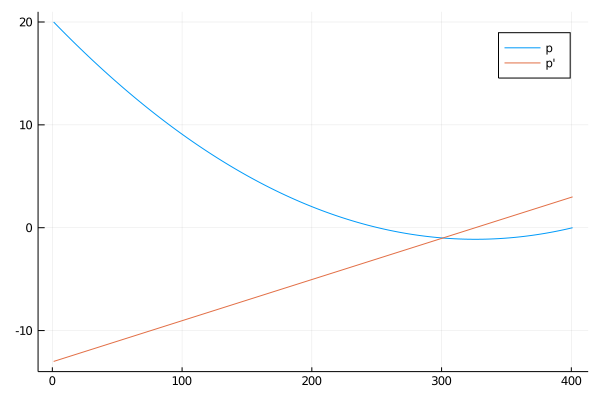

In [22]:
#This exercise is so short that I do not think that writing function "plot polynomials" is useful, I write it as a script 
#firstly, I copy the code from the exercise
p = Polynomial([2, -5, 2])  # :x just gives a symbol for display

@show p
p_prim = Polynomials.derivative(p)   # gives the derivative of p, another polynomial
@show p(0.1), p_prim(0.1)  # call like a function
@show roots(p);   # find roots such that p(x) = 0

#Next I initilalize x nfor which I will plot, 
 x = -2.0:0.01:2.0
#plot polynomials
plot(p.(x), label="p")
plot!( p_prim.(x), label = "p' ")